# Stage 13 Homework Starter — Productization

## Objective
Deploy your trained model as a **reusable, handoff-ready API or dashboard** and finalize your project for reproducibility and clarity.

## Steps
1. Create a mock, very basic analysis in a notebook.
2. Clean your notebook by removing exploratory cells and documenting your code.
3. Move reusable functions into `/src/`.
4. Load your trained model from Stage 12 or earlier stages.
5. Pickle/save the model and test reload.
6. Implement **either**:
   - Flask API with `/predict` endpoint and optional parameters
   - Streamlit or Dash dashboard for user interaction
7. Include:
   - Error handling for invalid inputs
   - `requirements.txt` for reproducibility
   - Documentation in `README.md`
8. Test your deployment locally and provide evidence.
9. Organize project folders and finalize notebooks for handoff.

## Create mock, very basic analysis

In [1]:
# 1) Imports & setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
# 2) Load / create mock data
df = pd.DataFrame({'x': [1, 2, 3, 4], 'y': [2, 5, 6, 9]})
display(df)

,x,y
0,1,2
1,2,5
2,3,6
3,4,9


In [3]:
# 3) Fit a simple linear model
X = df[['x']].values
y = df['y'].values
model = LinearRegression().fit(X, y)
coef = float(model.coef_[0])
intercept= float(model.intercept_)
print(f"Fitted model: y = {coef:.3f} * x + {intercept:.3f}")

Fitted model: y = 2.200 * x + 0.000


In [4]:
# 4) Predict on new x values
x_new = np.array([5, 6, 7]).reshape(-1, 1)
y_pred = model.predict(x_new)

pred_df = pd.DataFrame({'x_new': x_new.ravel(), 'y_pred': y_pred})
display(pred_df)

,x_new,y_pred
0,5,11.0
1,6,13.2
2,7,15.4


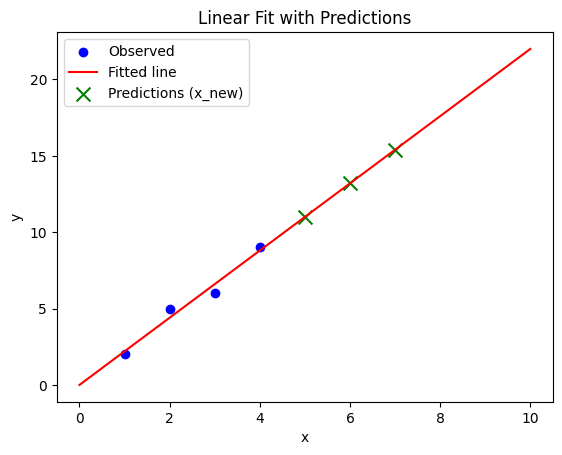

In [5]:
# 5) Visualization 

# Line fit from 0 to 10
x_line = np.linspace(0, 10, 100).reshape(-1, 1)
y_line = model.predict(x_line)
plt.figure()
# training data
plt.scatter(df['x'], df['y'], label='Observed', color='blue')
# fitted line
plt.plot(x_line, y_line, label='Fitted line', color='red')
# new predictions
plt.scatter(x_new, y_pred, label='Predictions (x_new)', color='green', marker='x', s=100)
plt.title('Linear Fit with Predictions')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [6]:
print("Notebook cleaned and ready for handoff.")

Notebook cleaned and ready for handoff.


## Move reusable functions to /src/

In [7]:
def mean_impute(a: np.ndarray) -> np.ndarray:
    m = np.nanmean(a)
    out = a.copy()
    out[np.isnan(out)] = m
    return out

def median_impute(a: np.ndarray) -> np.ndarray:
    m = np.nanmedian(a)
    out = a.copy()
    out[np.isnan(out)] = m
    return out

class SimpleLinReg:
    def fit(self, X, y):
        X1 = np.c_[np.ones(len(X)), X.ravel()]
        beta = np.linalg.pinv(X1) @ y
        self.intercept_, self.coef_ = float(beta[0]), np.array([float(beta[1])])
        return self
    def predict(self, X):
        return self.intercept_ + self.coef_[0] * X.ravel()

def mae(y_true, y_pred):
    return float(np.mean(np.abs(y_true - y_pred)))

def bootstrap_metric(y_true, y_pred, fn, n_boot=500, seed=111, alpha=0.05):
    rng = np.random.default_rng(seed)
    idx = np.arange(len(y_true))
    stats = []
    for _ in range(n_boot):
        b = rng.choice(idx, size=len(idx), replace=True)
        stats.append(fn(y_true[b], y_pred[b]))
    lo, hi = np.percentile(stats, [100*alpha/2, 100*(1-alpha/2)])
    return {'mean': float(np.mean(stats)), 'lo': float(lo), 'hi': float(hi)}

def fit_fn(X, y):
    return SimpleLinReg().fit(X, y)
def pred_fn(model, X):
    return model.predict(X)

## Pickle / Save Final Model


In [9]:
import pickle
# Replace 'model' with your trained model variable
with open('model/model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Test loading the model
with open('model/model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Example prediction (replace with actual features)
print(loaded_model.predict(np.array([0.1, 0.2, 0.3]).reshape(-1, 1)))

[0.22 0.44 0.66]


## Flask API Starter


In [ ]:
from flask import Flask, request, jsonify
import threading
import matplotlib.pyplot as plt
import io
import base64

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    # TODO: Replace placeholder logic with actual model prediction
    data = request.get_json()
    features = data.get('features', None)
    if features is None:
        return jsonify({'error': 'No features provided'}), 400
    X = np.array(features).reshape(-1, model.n_features_in_)  # ensure 2D
    y_pred = model.predict(X)
    pred = y_pred.tolist()
    return jsonify({'prediction': pred})

@app.route('/predict/<float:input1>', methods=['GET'])
def predict_one(input1):
    X = np.array([[input1]])
    pred = model.predict(X)[0]
    return jsonify({'prediction': pred})


@app.route('/plot')
def plot():
    # TODO: Replace with meaningful chart or image
    fig, ax = plt.subplots()
    x_line = np.linspace(0, 20, 100).reshape(-1, 1)
    y_line = model.predict(x_line)
    ax.plot(x_line.ravel(), y_line, color='red', label='Model prediction')
    ax.legend()
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    img_bytes = base64.b64encode(buf.read()).decode('utf-8')
    return f'<img src="data:image/png;base64,{img_bytes}"/>'

def run_flask():
    app.run(port=5000)

# Launch Flask in a separate thread
threading.Thread(target=run_flask).start()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [28/Aug/2025 09:10:26] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [28/Aug/2025 09:10:26] "GET /predict/2.0 HTTP/1.1" 200 -
127.0.0.1 - - [28/Aug/2025 09:10:26] "GET /plot HTTP/1.1" 200 -


## Testing the Flask API from Notebook


{'prediction': [0.22000000000000172, 0.44000000000000167, 0.6600000000000016]}
{'prediction': 4.4}



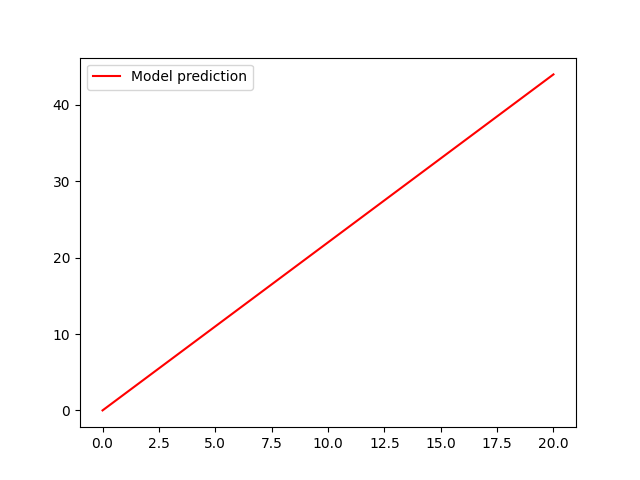

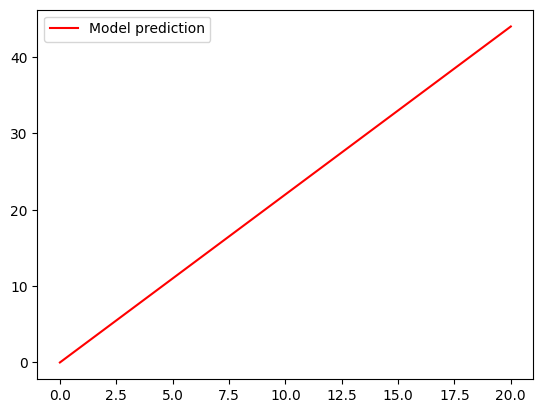

In [12]:
import requests
from IPython.display import display, HTML

# POST /predict
response = requests.post(
    'http://127.0.0.1:5000/predict',
    json={'features':[0.1, 0.2, 0.3]}
)
print(response.json())

# GET /predict/<input1>
response2 = requests.get('http://127.0.0.1:5000/predict/2.0')
print(response2.json())

# GET /predict/<input1>/<input2>
# response3 = requests.get('http://127.0.0.1:5000/predict/1.0/3.0')
# print(response3.json())

# GET /plot
response_plot = requests.get('http://127.0.0.1:5000/plot')
display(HTML(response_plot.text))